In [1]:
%load_ext autoreload
%autoreload 2  
%reload_ext autoreload

In [2]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.optimize import minimize
import tqdm

import nlopt
from functools import partial
from bgspy.likelihood import negll_softmax_full2, negll_c, negll_simplex_full2

from bgspy.likelihood import SimplexModel, FreeMutationModel
from bgspy.utils import load_pickle
from bgspy.optim import optim_plot, run_optims
from bgspy.optim import equality_constraint_function, inequality_constraint_functions
from bgspy.optim import optim_diagnotics_plot

/home/vsb/projects/bprime/bgspy/likelihood.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  import tqdm.autonotebook as tqdm


In [3]:
plt.show()
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

# MLE Diagnostics

### Merged Model

This is the simplest model, all CDS+phastcons+UTRs are merged into a single conserved feature type. The mixture with UTRs adds some complexity, since these are much less conserved.

In [29]:
fmd = load_pickle('../fits/hg38_cds_utrs_phastcons_merged_simplex/model_data_1000000.pkl')
#fd = load_pickle('../fits/hg38_cds_utrs_phastcons_simplex/model_data_1000000.pkl')
fd = load_pickle('../fits/hg38_cds_utrs_phastcons_simplex_full/model_data_1000000.pkl')

In [30]:
from bgspy.likelihood import negll_c

In [31]:
dat = fd
gm, Y, bgs_bins, features, bp = dat['gm'], dat['Y'], dat['bgs_bins'], dat['gm'].features, dat['bp']

mb = SimplexModel(w=gm.w, t=gm.t, logB=bp, Y=Y,
                  bins=bgs_bins, features=features) 

In [32]:
start = mb.random_start()
negll_c(start, Y, bp, mb.w, two_alleles=False, version=1)

544552287672.2677

In [33]:
negll_c(start, Y, bp, mb.w, two_alleles=False, version=2)

544552287672.2677

In [34]:
from scipy.optimize import curve_fit
import tqdm 

np.seterr(under='ignore')
    
def mut_curve(x, a):
    return np.exp(-a * x)

def fit_B_curve_params(b, w):
    nx, nw, nt, nf = b.shape
    params = np.empty((nx, 1, nt, nf))
    for i in tqdm.tqdm(range(nx)):
        for j in range(nt):
            for k in range(nf):
                popt, pcov = curve_fit(mut_curve, w, np.exp(b[i, :, j, k]))
                assert(len(popt) == 1)
                params[i, 0, j, k] = popt[0]
    return params

B_fit = fit_B_curve_params(bp, mb.w)

  3%|██████▏                                                                                                                                                                                               | 78/2496 [00:00<00:19, 123.84it/s]/home/vsb/miniconda3/envs/bprime/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2496/2496 [00:20<00:00, 123.07it/s]


[]

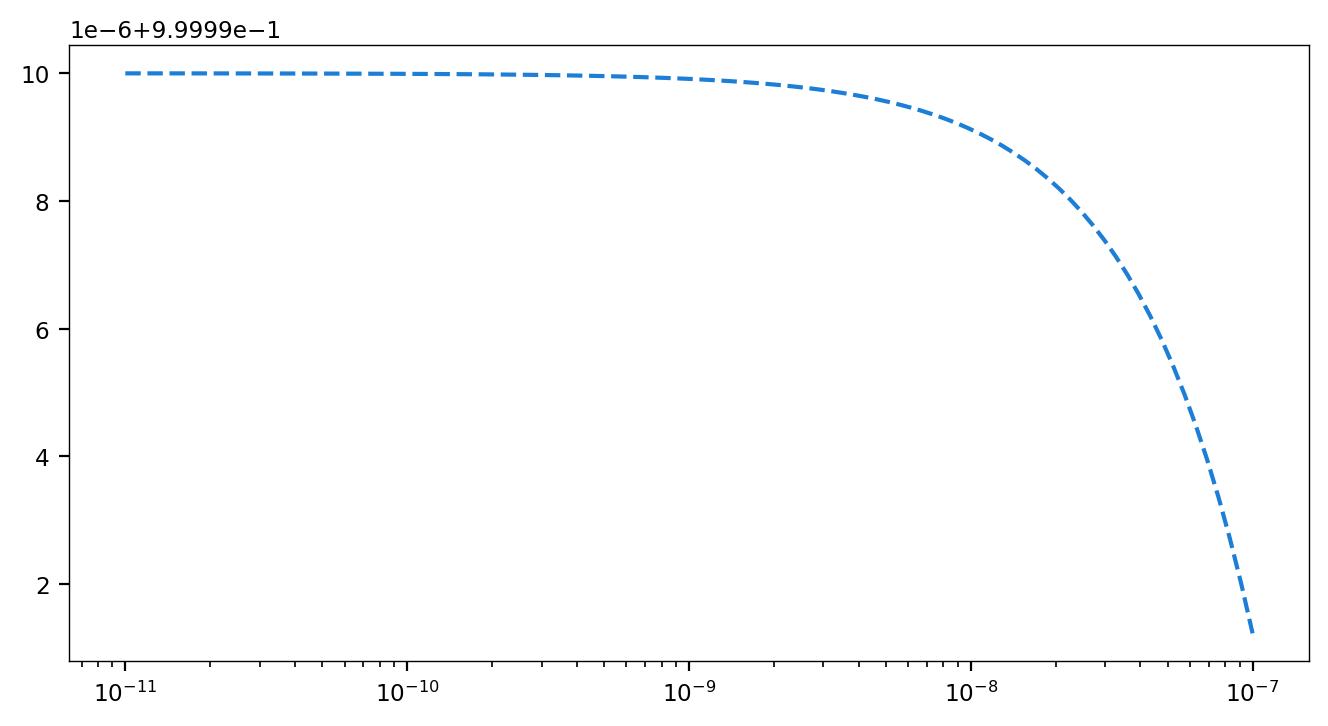

In [10]:
x = np.logspace(np.log10(mb.w[0]), np.log10(mb.w[-1]), 100)

plt.plot(x, mut_curve(x, B_fit[1000, 0, 0, 0]), linestyle='dashed')
plt.semilogx()

In [35]:
mb.logB_fit = B_fit

### Experiments

In [36]:
nt, nf = mb.nt, mb.nf

In [37]:
from bgspy.likelihood import random_start_simplex, negll_softmax_full2, negll_softmax_full
from bgspy.optim import convert_softmax

In [38]:
def nlopt_softmax_worker(start, func, nt, nf, algo='LD_LBFGS', xtol_rel=1e-3):
    lb = [1e-5, 1e-11] + [-np.inf]*(nt*nf)
    ub = [1e-2, 1e-7] + [np.inf]*(nt*nf)   
    nparams = nt*nf + 2
    opt = nlopt.opt(algo, nparams)
    opt.set_min_objective(func)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_xtol_rel(xtol_rel)
    maxeval = int(1e6)
    opt.set_maxeval(maxeval)
    try:
        mle = opt.optimize(start)
    except:
        return 0, 0, 0
    mle = convert_softmax(mle, nt, nf)
    nll = opt.last_optimum_value()
    success = opt.last_optimize_result()
    return nll, mle, success


def scipy_softmax_worker(start, func, nt, nf, method='L-BFGS-B'):
    lb = [1e-5, 1e-11] + [-np.inf]*(nt*nf)
    ub = [1e-2, 1e-7] + [np.inf]*(nt*nf)   
    nparams = nt*nf + 2
    res = minimize(func, start, bounds=list(zip(lb, ub)), method=method)
    nll = res.fun
    mle = res.x
    mle = convert_softmax(mle, nt, nf)
    success = int(res.success) # this is so it matches nlopt
    return nll, mle, success

In [63]:
nll_func = partial(negll_softmax_full2, Y=Y, B=B_fit, w=mb.w)

res = run_optims(partial(scipy_softmax_worker, func=nll_func, nt=nt, nf=nf), 
                [mb.random_start(softmax=True) for x in range(50000)],
                ncores=70)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [34:25<00:00, 24.20it/s]


In [64]:
mb._load_optim(res)

In [67]:
mb

MLE (interpolated w): 6 x 7 x 4
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates: (whole genome)
negative log-likelihood: 322732201191.9818
π0 = 0.001554282653763358
μ = 1.7538771973765688e-08
R² = 68.5459
W = 
          cds    other    phastcons    utr
------  -----  -------  -----------  -----
1e-07   0.039    0.999        0.003  0.012
1e-06   0.172    0            0.003  0.023
1e-05   0.045    0            0.003  0.023
0.0001  0.007    0            0.001  0.101
0.001   0.008    0            0.312  0.181
0.01    0.081    0            0.133  0.099
0.1     0.648    0            0.546  0.56

In [53]:
mb

MLE (interpolated w): 6 x 7 x 4
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates: (whole genome)
negative log-likelihood: 322739700238.0344
π0 = 0.0015433007271146598
μ = 1.2951198659212487e-08
R² = 67.5977
W = 
          cds    other    phastcons    utr
------  -----  -------  -----------  -----
1e-07   0.021    0.847        0.029  0.176
1e-06   0.107    0.084        0.074  0.111
1e-05   0.067    0.001        0.03   0.048
0.0001  0.029    0            0.006  0.051
0.001   0.028    0            0.37   0.204
0.01    0.72     0.001        0.439  0.115
0.1     0.029    0.066        0.052  0.295

In [54]:
mb.features

['cds', 'other', 'phastcons', 'utr']

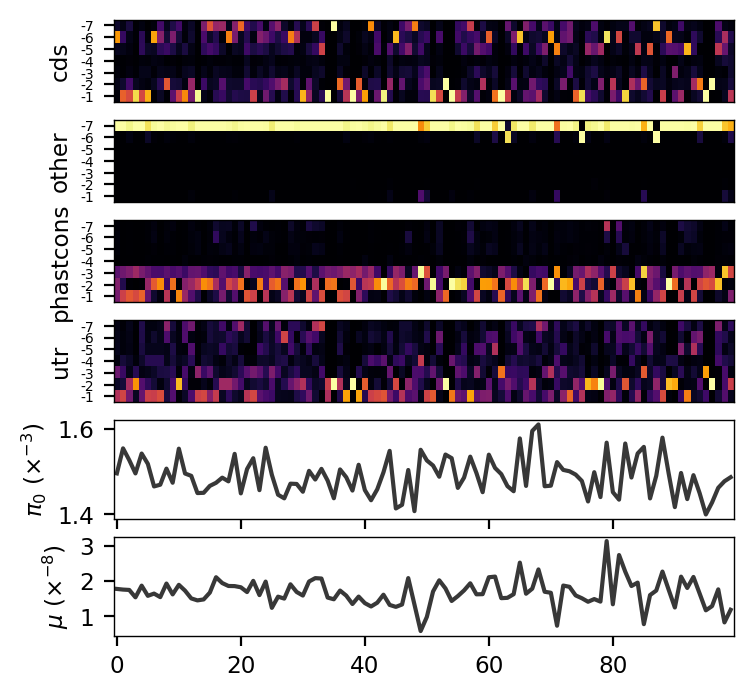

In [101]:
optim_diagnotics_plot(mb, figsize=(4, 4))

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

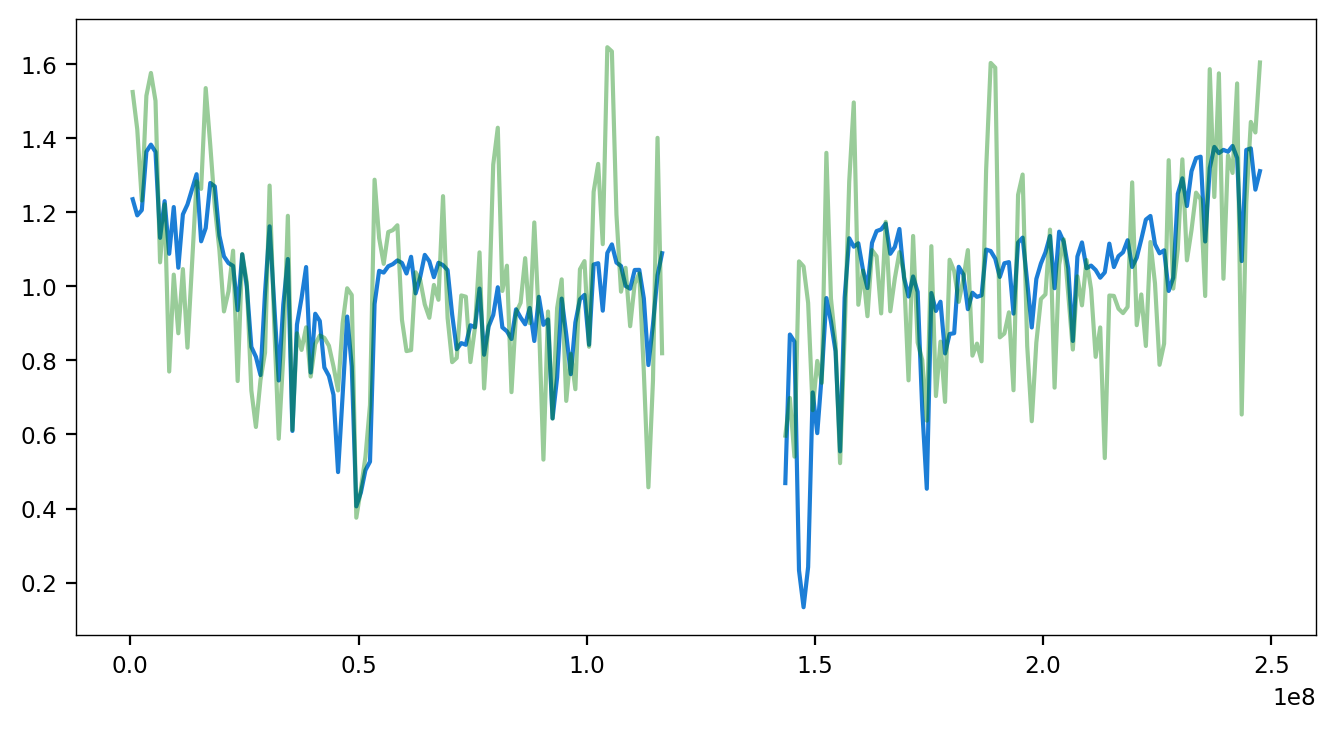

In [102]:
mb.predict_plot('chr1')

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot: xlabel='predicted $\\hat{\\pi}$', ylabel='residuals'>)

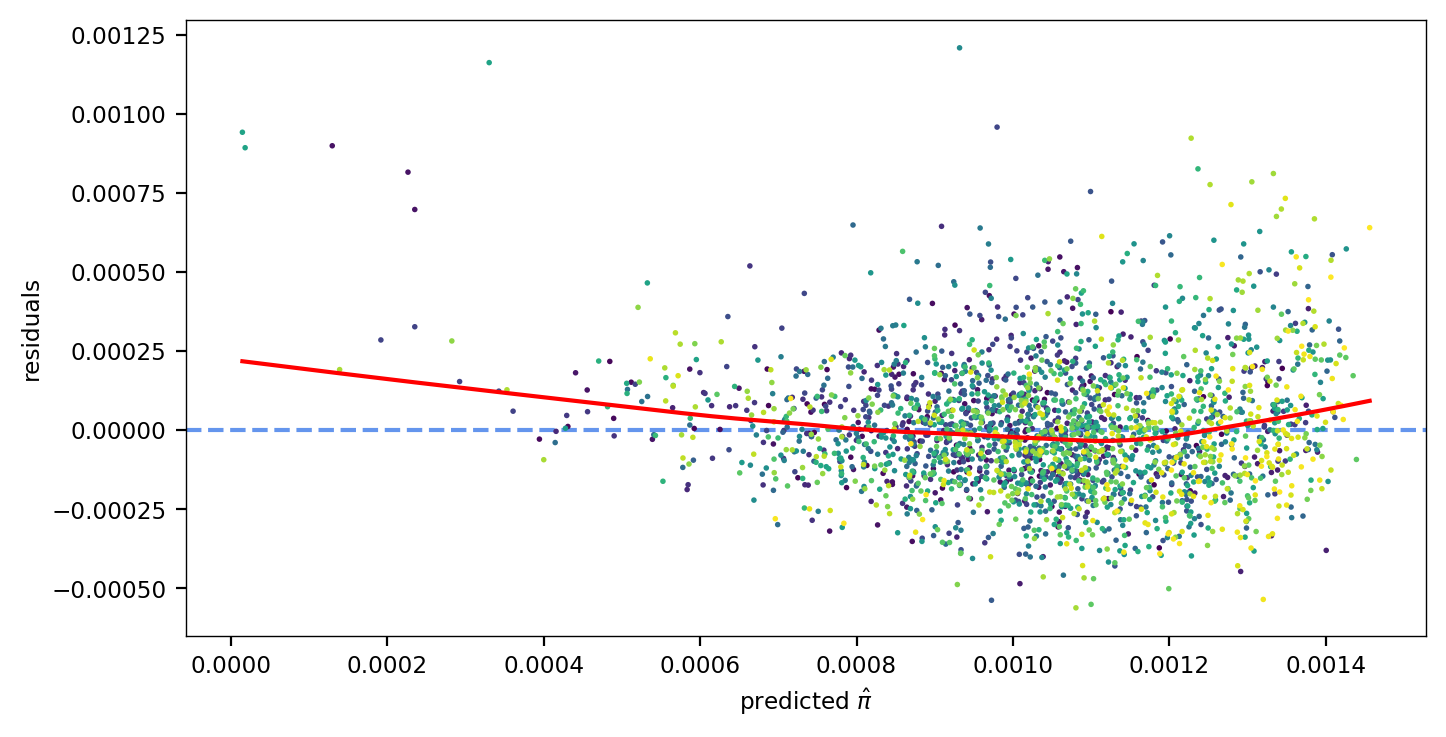

In [103]:
mb.resid_fitted_plot()

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

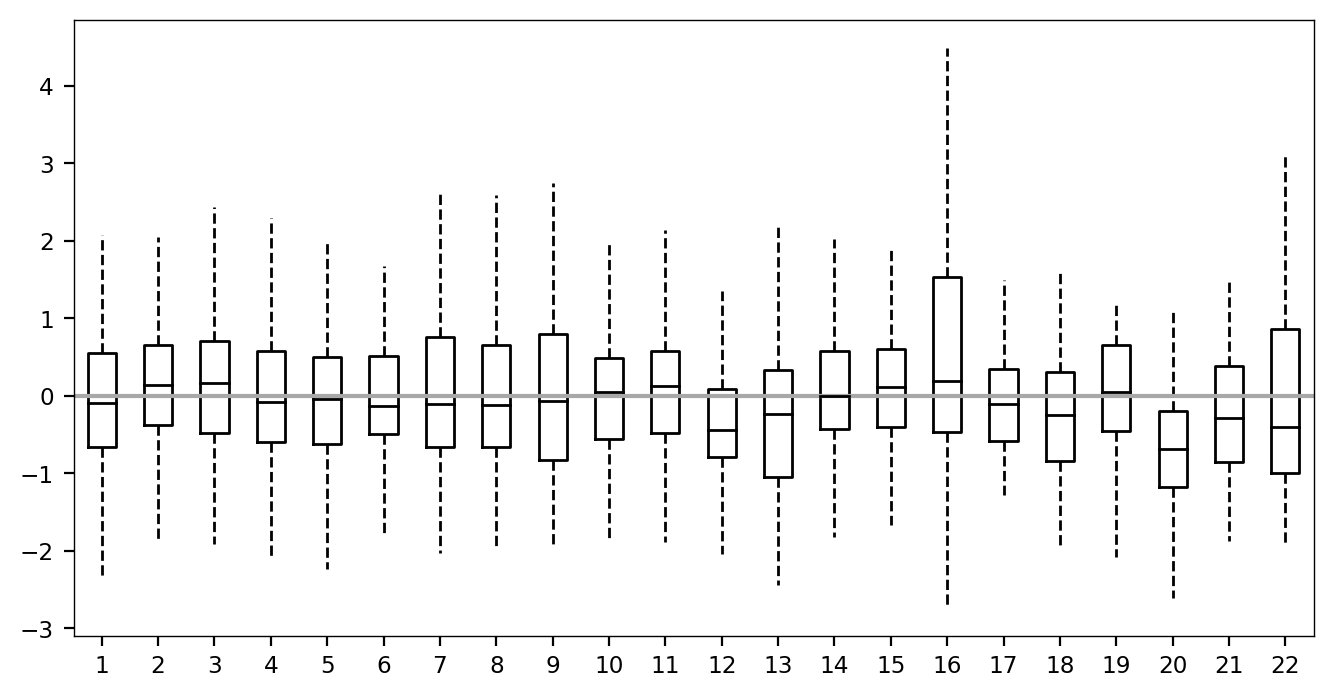

In [104]:
mb.chrom_resid_plot()

In [105]:
mb

MLE (interpolated w): 6 x 7 x 4
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates: (whole genome)
negative log-likelihood: 322732201191.9818
π0 = 0.001554282653763358
μ = 1.7538771973765688e-08
R² = 68.5459
W = 
          cds    other    phastcons    utr
------  -----  -------  -----------  -----
1e-07   0.039    0.999        0.003  0.012
1e-06   0.172    0            0.003  0.023
1e-05   0.045    0            0.003  0.023
0.0001  0.007    0            0.001  0.101
0.001   0.008    0            0.312  0.181
0.01    0.081    0            0.133  0.099
0.1     0.648    0            0.546  0.56

(<Figure size 1600x800 with 6 Axes>,
 array([<AxesSubplot: ylabel='cds'>, <AxesSubplot: ylabel='other'>,
        <AxesSubplot: ylabel='phastcons'>, <AxesSubplot: ylabel='utr'>,
        <AxesSubplot: ylabel='$\\pi_0$ ($\\times^{-3}$)'>,
        <AxesSubplot: ylabel='$\\mu$ ($\\times^{-8}$)'>], dtype=object))

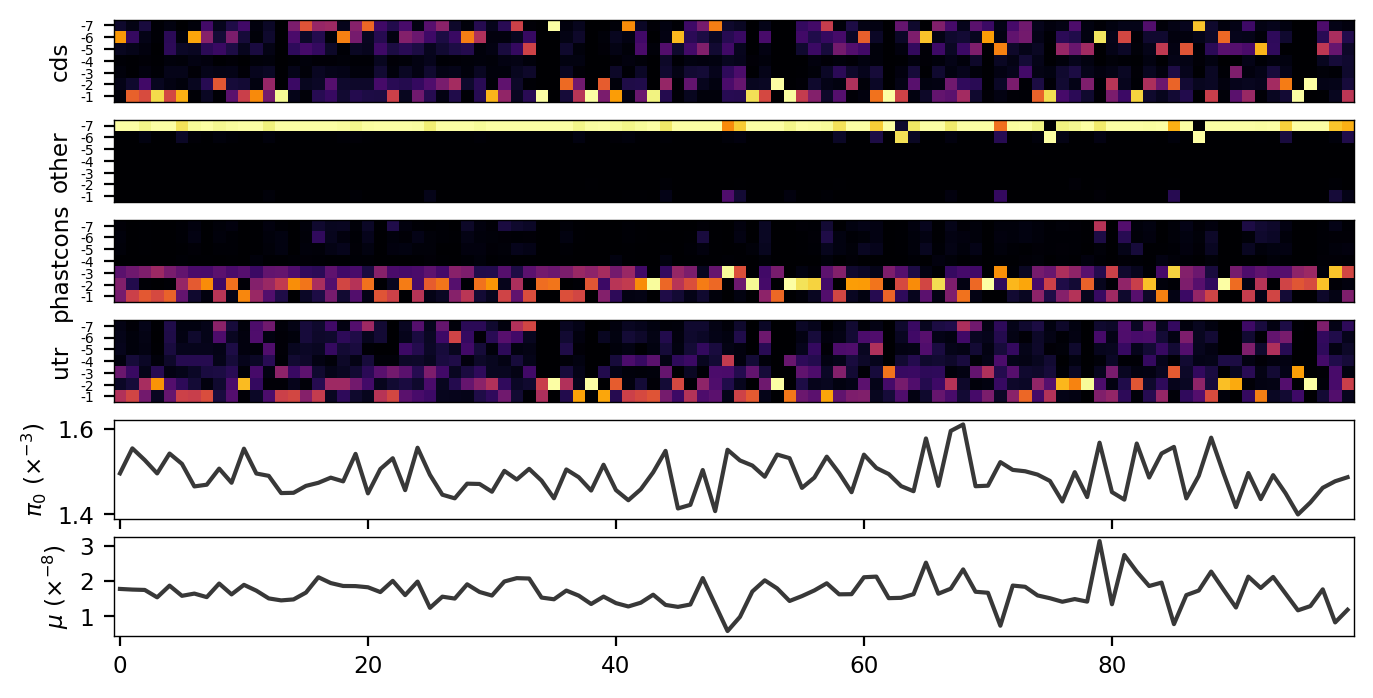

In [106]:
optim_diagnotics_plot(mb)

In [ ]:
import nlopt
from functools import partial
from bgspy.likelihood import negll_softmax_full2, negll_c, negll_simplex_full2
#minimize(partial(negll_softmax_full2, Y=Y, B=B_fit, w=mb.w), mb.random_start(softmax=True))

In [ ]:
start = mb.random_start()
negll_c(start, Y, bp, mb.w, two_alleles=False, version=2)

400697033738.0451

In [ ]:
start = mb.random_start()

negll_c(start, Y, B_fit, mb.w, two_alleles=False, version=3)

325812374297.61066

In [ ]:
def func(theta):
    #return negll_simplex_full2(theta, Y=Y, B=B_fit, w=mb.w)
    return negll_softmax_full2(theta, Y=Y, B=B_fit, w=mb.w)

In [ ]:
res = minimize(func, mb.random_start(softmax=True), 
               method='L-BFGS-B',
               #method='Nelder-Mead',               
               bounds=mb.bounds(paired=True, softmax=True)
              )
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 322804461104.4069
        x: [ 1.321e-03  9.000e-09 ...  5.436e+00 -1.725e+00]
      nit: 22
      jac: [-3.267e+11  1.663e+17 ... -2.075e+05 -1.465e+05]
     nfev: 4743
     njev: 153
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>

In [ ]:
def convert_softmax(theta_sm):
    theta = np.copy(theta_sm)
    theta[2:] = softmax(theta[2:].reshape(mb.nt, mb.nf), axis=0).flat
    return theta[:2], np.round(theta[2:].reshape(mb.nt, mb.nf), 3)


In [ ]:
convert_softmax(res.x)

(array([1.32056557e-03, 9.00000000e-09]),
 array([[0.053, 1.   , 0.   , 0.18 ],
        [0.477, 0.   , 0.   , 0.127],
        [0.037, 0.   , 0.   , 0.213],
        [0.011, 0.   , 0.   , 0.145],
        [0.037, 0.   , 0.997, 0.104],
        [0.338, 0.   , 0.   , 0.212],
        [0.047, 0.   , 0.002, 0.019]]))

In [ ]:
features

['cds', 'other', 'phastcons', 'utr']

In [ ]:
for i in range(1000):
    start = mb.random_start()
    assert(negll_c(start, Y, bp, mb.w, version=1) == negll_c(start, Y, bp, mb.w, version=2))

AssertionError: 

In [ ]:
negll_c(start, Y, bp, mb.w, version=1), negll_c(start, Y, bp, mb.w, version=2)

(-0.001818396303558564, 389364449395.8094)

In [ ]:
start = mb.random_start()
negll_c(start, Y, bp, mb.w), negll_c(start, Y, bp, mb.w, version2=True)

(565344378126.4197, 565344378126.4197)

In [ ]:
%%timeit
negll_c(mb.random_start(), Y, bp, mb.w, version2=False)

636 µs ± 2.86 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%%timeit
negll_c(mb.random_start(), Y, bp, mb.w, version2=True)

351 µs ± 4.52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
features = gm.features

In [ ]:
features

['cds', 'other', 'phastcons', 'utr']

In [ ]:
gm.w, Y.shape

(array([1.00000000e-11, 6.30957344e-11, 3.98107171e-10, 2.51188643e-09,
        1.58489319e-08, 1.00000000e-07]),
 (2496, 2))

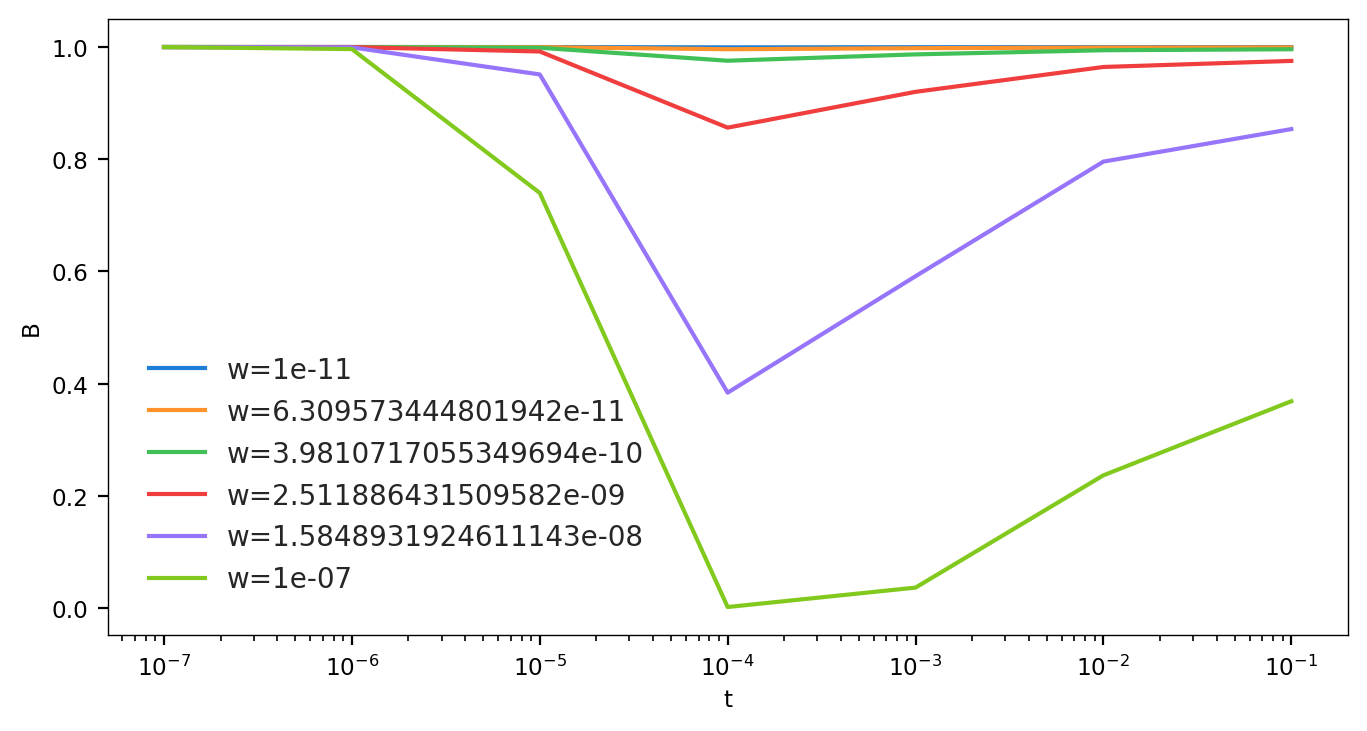

In [ ]:
for i, w in enumerate(gm.w):
    plt.plot(gm.t, np.exp(bp[10, i, :, 0]), label=f"w={w}")
    plt.semilogx()
    plt.ylabel('B')
    plt.xlabel('t')
plt.legend()

[]

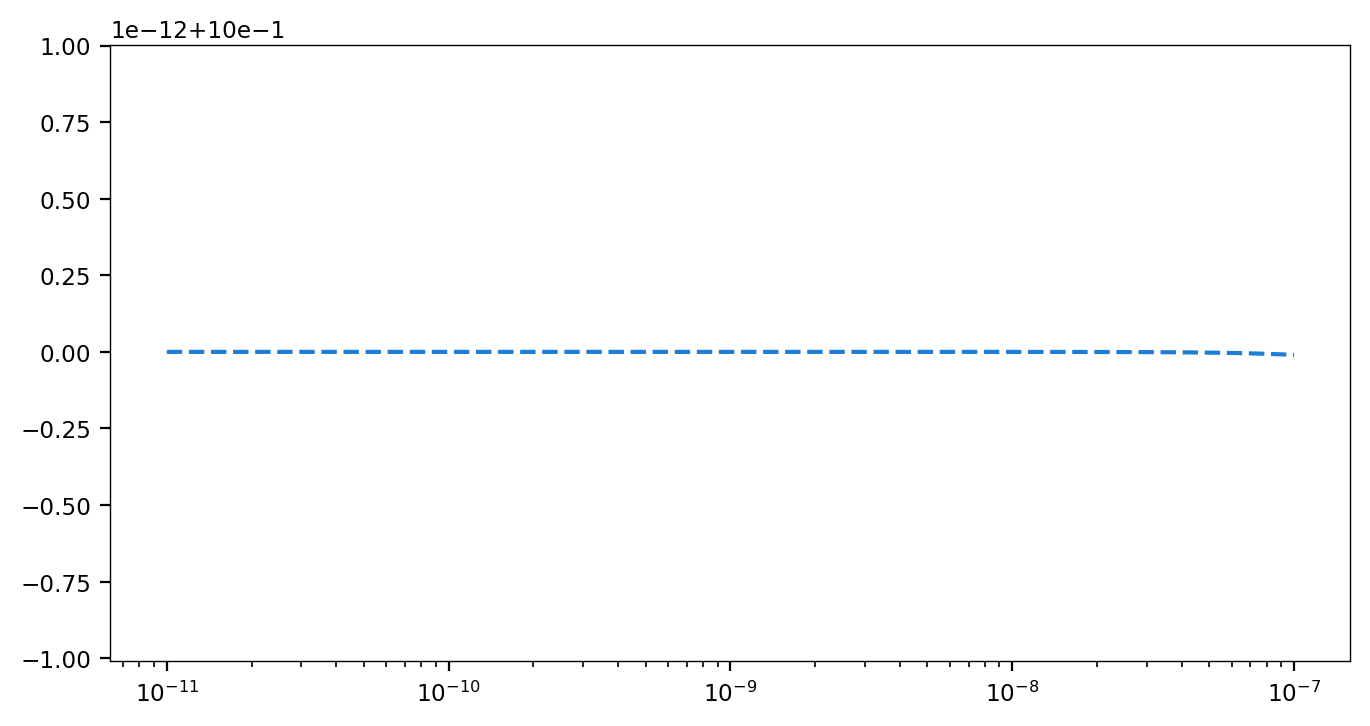

In [ ]:
x = np.logspace(np.log10(mb.w[0]), np.log10(mb.w[-1]), 100)

plt.plot(x, mut_curve(x, B_fit[1000, 0, 0, 0]), linestyle='dashed')
plt.semilogx()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


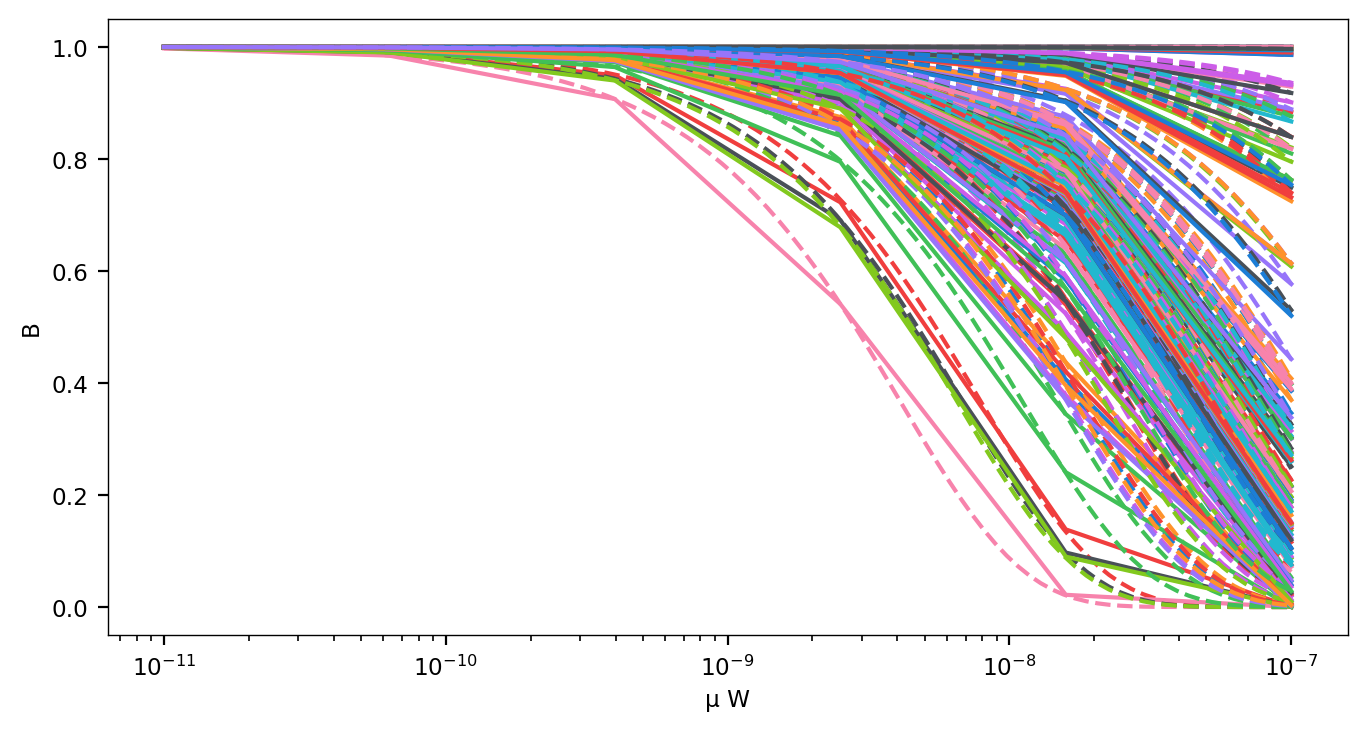

In [ ]:
f = 2
params = []
for i in range(0, bp.shape[0], 100):
    for j, t in enumerate(gm.t):
        lines = plt.plot(gm.w, np.exp(bp[i, :, j, f]))
        popt, pcov = curve_fit(mut_curve, mb.w, np.exp(bp[i, :, j, f]))
        params.append(popt)
        x = np.logspace(np.log10(mb.w[0]), np.log10(mb.w[-1]), 100)
        
        plt.plot(x, mut_curve(x, *popt), c=lines[0].get_color(), linestyle='dashed')
        
plt.ylabel('B')
plt.xlabel('μ W')


plt.semilogx()
plt.legend()
#plt.ylim(0.99, 1)

In [ ]:
popt

array([427500.75473949])

In [ ]:
np.stack(params).min()

0.005613497197459294

In [ ]:
popt

array([427500.75473949])

In [ ]:
from scipy.optimize import curve_fit

def mut(x, a):
    return np.exp(-a * x*2)

popt, pcov = curve_fit(mut, mb.w, np.exp(bp[1, :, 1, 0]))

In [ ]:
mut(mb.w, *popt)

array([0.99999986, 0.99999913, 0.9999945 , 0.99996527, 0.99978088,
       0.99861824])

In [ ]:
popt

array([427500.75473949])

[]

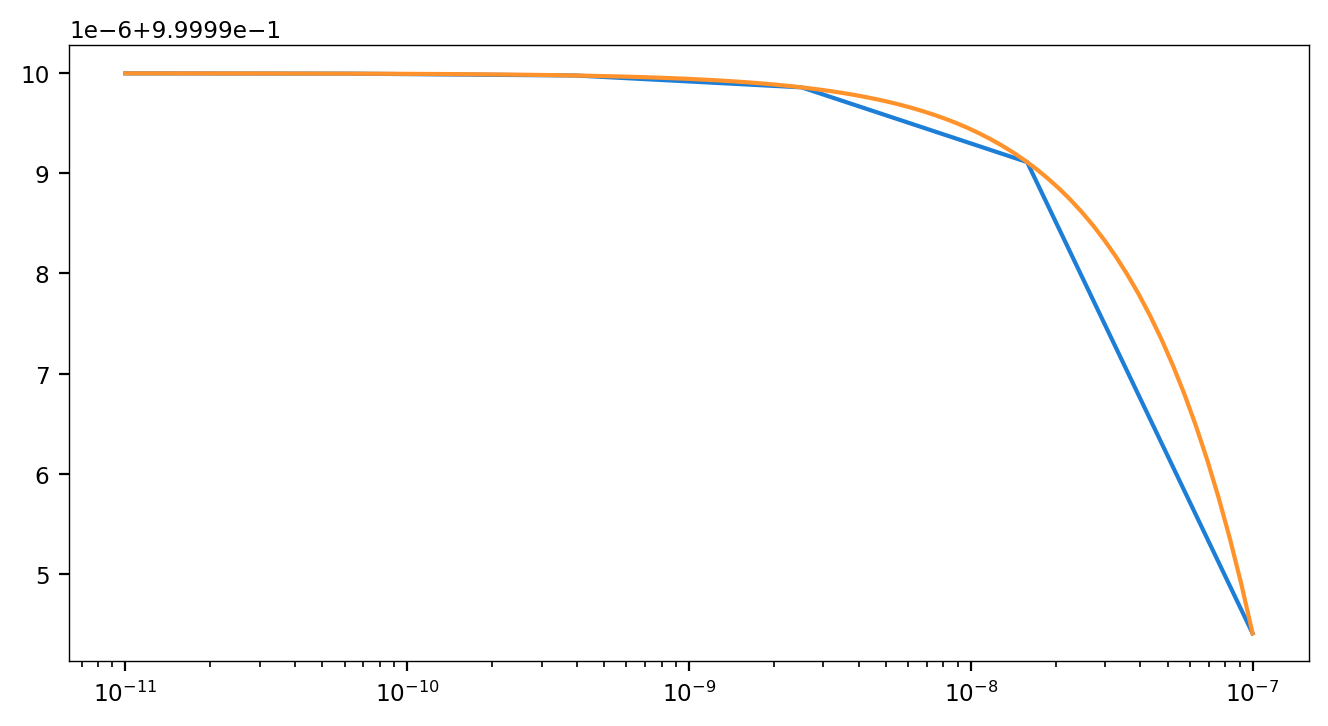

In [ ]:
i = 400
j = 1

plt.plot(mb.w, np.exp(bp[i, :, j, 0]))

popt, pcov = curve_fit(mut, mb.w, np.exp(bp[i, :, j, 0]))

x = np.logspace(np.log10(mb.w[0]), np.log10(mb.w[-1]), 100)
plt.plot(x, mut(x, *popt))
plt.semilogx()

In [ ]:
mb.bounds()

(array([5.e-04, 9.e-09, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00]),
 array([5.e-03, 5.e-08, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
        1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
        1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
        1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00]))

In [ ]:
%%time

mb = SimplexModel(w=gm.w, t=gm.t, logB=bp, Y=Y,
                  bins=bgs_bins, features=features) 

mb.logB_fit = B_fit
mb.fit(starts=100, ncores=False1, #least_squares=True,
       #algo='GN_DIRECT_L'
       #algo='GN_ISRES'
       #algo='LD_LBFGS'
, 
       softmax=      )

  0%|                                                                                                                                                                                                                 | 0/100 [01:38<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
mb

MLE (interpolated w): 6 x 7 x 4
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates: (whole genome)
negative log-likelihood: nan
π0 = 0.004247286184823573
μ = 3.406236383883387e-08
R² = 52.2051
W = 
          cds    other    phastcons    utr
------  -----  -------  -----------  -----
1e-07   0.027    0.074        0.18   0.162
1e-06   0.137    0.006        0.021  0.028
1e-05   0.079    0.211        0.121  0.305
0.0001  0.094    0.23         0.289  0.037
0.001   0.3      0.094        0.076  0.27
0.01    0.08     0.227        0.261  0.142
0.1     0.282    0.158        0.053  0.056

In [ ]:
minimize

<function scipy.optimize._minimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)>

In [ ]:
mb

MLE (interpolated w): 6 x 7 x 4
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates: (whole genome)
negative log-likelihood: nan
π0 = 0.0044565031236923945
μ = 3.866602696234712e-08
R² = 59.5042
W = 
          cds    other    phastcons    utr
------  -----  -------  -----------  -----
1e-07   0.083    0.084        0.141  0.105
1e-06   0.043    0.069        0.212  0.219
1e-05   0.15     0.621        0.078  0.313
0.0001  0.092    0.088        0.214  0.044
0.001   0.067    0.069        0.014  0.066
0.01    0.052    0.041        0.17   0.16
0.1     0.513    0.027        0.172  0.093

/home/vsb/projects/bprime/bgspy/optim.py:338: UserWarning: top_n < number of optimization results, truncating!
  warnings.warn(msg)


TypeError: 'BGSModel' object is not subscriptable

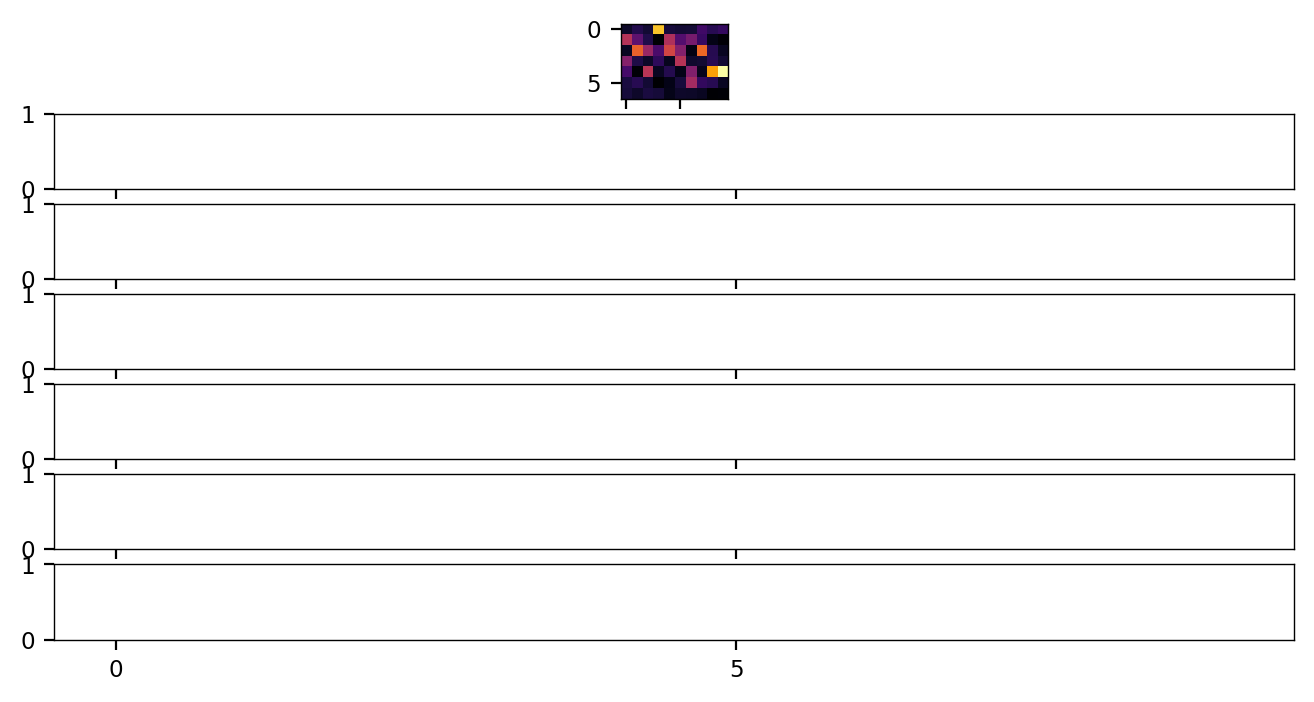

In [ ]:
optim_diagnotics_plot(mb)

### Experiments

In [ ]:
from bgspy.likelihood import negll_simplex_full, negll_softmax_full
from functools import partial

In [ ]:
MU_SCALE = 1e-8
PI_SCALE = 1e-4

def negll_simplex_rescaled(theta_scaled, grad, Y, B, w):
    mu = theta_scaled[1] * MU_SCALE
    pi0 = theta_scaled[0] * PI_SCALE
    theta = np.copy(theta_scaled)
    theta[1] = mu
    theta[0] = pi0
    return negll_softmax_full(theta, grad, Y, B, w)
    #return negll_simplex_full(theta, grad, Y, B, w)

def rescale_start(theta):
    theta_scaled = np.copy(theta)
    theta_scaled[0] = theta_scaled[0] / PI_SCALE
    theta_scaled[1] = theta_scaled[1] / MU_SCALE
    for i in range(2, len(theta)-2):
        theta_scaled[i] = np.random.normal(0, 1, 1)
    return theta_scaled


In [ ]:
mb = SimplexModel(w=gm.w, t=gm.t, logB=bp, Y=Y,
                  bins=bgs_bins, features=features) 

In [ ]:
mb.random_start(softmax=True)

array([ 9.30069283e-04,  1.12342943e-08,  4.33237242e-01,  6.76691046e-01,
       -9.21513913e-01, -2.92808455e-02,  5.72837673e-02, -3.99233420e-01,
        8.46382537e-01,  9.65363649e-01,  1.16402292e+00,  2.32116523e-01,
        5.32228853e-01, -9.05250353e-01, -5.67842798e-01, -1.23138048e+00,
        4.03098132e-01,  1.31571236e+00,  1.08127496e+00,  6.02274913e-01,
        1.92996730e+00,  4.76481377e-01,  3.42854744e-01])

In [ ]:
negll_softmax_full2

<function bgspy.likelihood.negll_softmax_full2(theta, Y, B, w)>

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: nan
        x: [-1.034e+03  1.752e+01 ...  7.155e-01  3.583e-01]
      nit: 1
      jac: [       nan        nan ...        nan        nan]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 3472
     njev: 112

In [ ]:
mle

array([ 2.72024023e-03,  4.66258799e-08, -6.67767017e-01,  5.02194121e-01,
        1.13068514e-01, -2.15417580e-01,  1.26931608e+00,  1.38853736e+00,
        9.18928895e-01, -1.68173022e+00,  9.93103129e-01,  1.29052410e+00,
        1.18415730e+00, -1.58571448e+00, -9.07449974e-01, -1.23557934e+00,
        6.30483530e-01, -3.94975062e-01,  2.11359631e+00, -2.66624748e-01,
       -2.31549191e+00, -7.74373339e-01, -2.77181706e+00,  4.57596836e-01,
        2.10869314e-01, -3.97882127e-01,  2.57367251e+00, -1.58015628e+00,
       -2.32041800e+00,  1.38213744e+00])

In [ ]:
def convert_softmax(theta_sm):
    theta = np.copy(theta_sm)
    theta[2:] = softmax(theta[2:].reshape(mb.nt, mb.nf), axis=0).flat
    return theta

#convert_softmax(mle)[2:].reshape(mb.nt, mb.nf)

In [ ]:
opt.last_optimum_value()

373094368885.5542

In [ ]:
#mb.fit(softmax=True, starts=100, algo='GN_DIRECT')

In [ ]:
mb

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

In [ ]:
#simplex_bounds = list(zip(*(rescale_start(mb.bounds()[0]), rescale_start(mb.bounds()[1]))))
simplex_bounds = list(zip(*(mb.bounds()[0], mb.bounds()[1])))
simplex_bounds[2:] = [(None, None)]*(len(simplex_bounds)-2)
#simplex_bounds = [(None, None)]*(len(simplex_bounds))
simplex_bounds

[(0.0004999999999999999, 0.004999999999999999),
 (9.000000000000006e-09, 4.999999999999999e-08),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None)]

In [ ]:
import multiprocessing
import tqdm
def opt(start):
    return minimize(partial(negll_softmax_full, grad=None, Y=Y, B=bp, w=gm.w), 
             bounds=simplex_bounds, 
             options={
                 #'maxiter': 1e6,
                 #'xatol': 1e-8,
                 #'adaptive': True,
                 #'fatol':1000
             },
             x0=start, 
             method='L-BFGS-B'
             #method='TNC',
             #method='Nelder-Mead'                   
            )

In [ ]:
%%time 
NS = 10000
with multiprocessing.Pool(70) as p:
    bfgs = list(tqdm.tqdm(p.imap(opt, [mb.random_start() for r in range(NS)]), total=NS))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [ ]:
nlls = np.array([r.fun for r in bfgs])
nll_idx = np.argsort(nlls)
min_i = nll_idx[1]
nlls[min_i]

323821632198.278

In [ ]:
a = bfgs

In [ ]:
nlls = [r.fun for r in a]
nll_idx = np.argsort(nlls)
min_i = nll_idx[0]
nlls[min_i]

322738283049.4047

In [ ]:
a[nll_idx[1]].message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [ ]:
nlls = [r.fun for r in a]
min_i = np.argmin(nlls)
nlls[min_i]

323801121624.9068

In [ ]:
nlls = [r.fun for r in a]
nll_idx = np.argsort(nlls)
min_i = nll_idx[0]
nlls[min_i]

323801121624.9068

In [ ]:
#a[min_i].x[0] * MU_SCALE, a[min_i].x[1] * PI_SCALE
a[min_i].x[0], a[min_i].x[1]

(0.001533083172058827, 2.6506112791649518e-08)

In [ ]:
a[min_i].x[2:].reshape(mb.nt, mb.nf)

array([[ 0.43861248, -4.21680667, -0.41721338],
       [ 0.15517384, -3.85119856, -0.37498927],
       [ 0.12812948, -3.34786117, -0.38944758],
       [-1.04376041,  1.24324774, -0.09469992],
       [-0.51169828,  3.89885981,  0.34790112],
       [ 0.04601103,  3.45602202,  0.10424261],
       [ 1.79367388,  3.87962057,  1.86482758]])

In [ ]:
a[nll_idx[0]].x

array([ 1.53308317e-03,  2.65061128e-08,  4.38612480e-01, -4.21680667e+00,
       -4.17213380e-01,  1.55173844e-01, -3.85119856e+00, -3.74989266e-01,
        1.28129483e-01, -3.34786117e+00, -3.89447575e-01, -1.04376041e+00,
        1.24324774e+00, -9.46999244e-02, -5.11698278e-01,  3.89885981e+00,
        3.47901120e-01,  4.60110345e-02,  3.45602202e+00,  1.04242613e-01,
        1.79367388e+00,  3.87962057e+00,  1.86482758e+00])

In [ ]:
np.seterr(under='ignore')
np.round(softmax(a[nll_idx[0]].x[2:].reshape(mb.nt, mb.nf), axis=0), 2)

array([[0.13, 0.  , 0.06],
       [0.1 , 0.  , 0.06],
       [0.1 , 0.  , 0.06],
       [0.03, 0.03, 0.08],
       [0.05, 0.37, 0.12],
       [0.09, 0.24, 0.09],
       [0.51, 0.36, 0.54]])

In [ ]:
np.round(softmax(a[nll_idx[1]].x[2:].reshape(mb.nt, mb.nf), axis=0), 2)

array([[0.22, 0.13, 0.21],
       [0.22, 0.18, 0.33],
       [0.22, 0.12, 0.18],
       [0.02, 0.02, 0.02],
       [0.06, 0.15, 0.04],
       [0.11, 0.15, 0.09],
       [0.15, 0.23, 0.14]])

In [ ]:
np.round(softmax(a[nll_idx[5]].x[2:].reshape(mb.nt, mb.nf), axis=0), 2)

array([[0.2 , 0.08, 0.18],
       [0.2 , 0.08, 0.25],
       [0.19, 0.07, 0.15],
       [0.03, 0.02, 0.02],
       [0.06, 0.11, 0.05],
       [0.12, 0.2 , 0.1 ],
       [0.2 , 0.43, 0.26]])

In [ ]:
dfes = []
for i in range(100):
    dfes.append(softmax(a[nll_idx[i]].x[2:].reshape(mb.nt, mb.nf), axis=0))

alpha = 0.05
#np.round(np.quantile(np.stack(dfes), (alpha/2, 1-alpha/2), axis=0), 3)
np.round(np.mean(np.stack(dfes), axis=0), 3)

array([[0.177, 0.037, 0.135],
       [0.182, 0.036, 0.131],
       [0.113, 0.024, 0.095],
       [0.011, 0.007, 0.014],
       [0.04 , 0.231, 0.043],
       [0.118, 0.363, 0.162],
       [0.358, 0.303, 0.419]])

In [ ]:
mb.features

['cds', 'phastcons', 'utr']

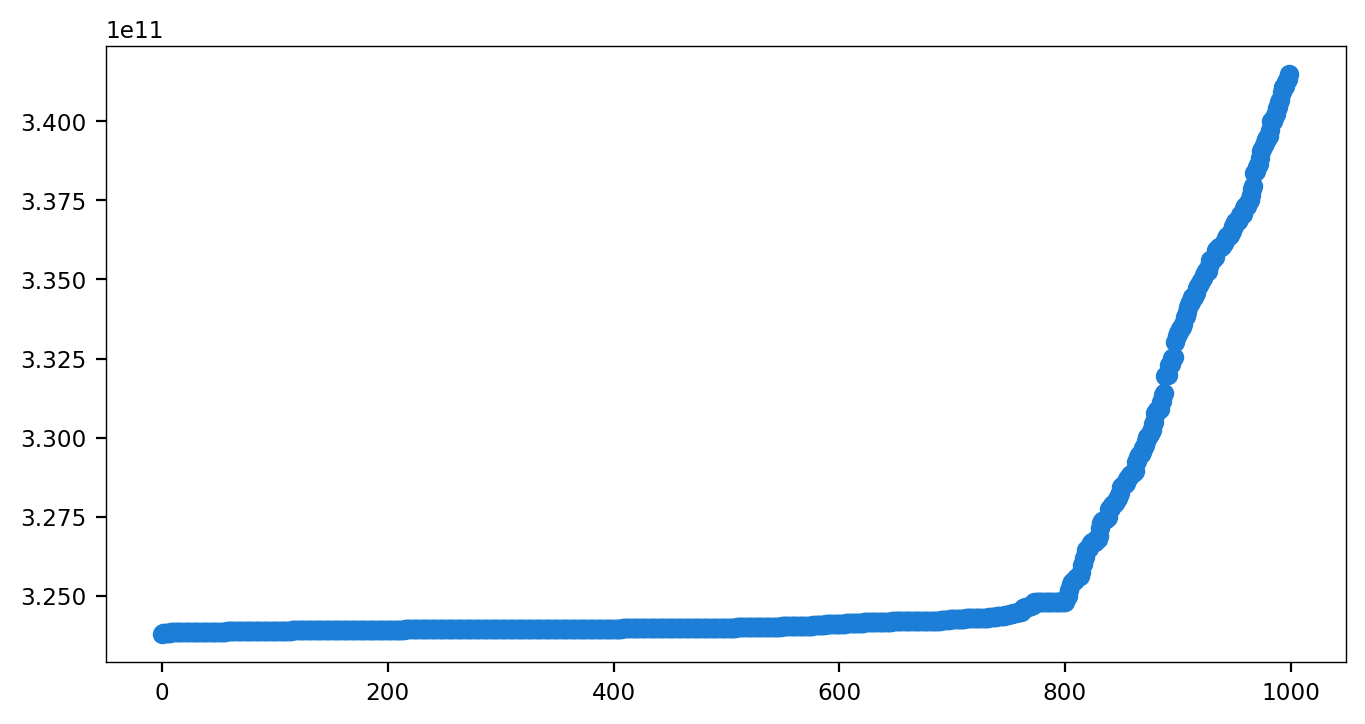

In [ ]:
plt.scatter(np.arange(len(nlls)), np.sort(nlls))

Text(0.5, 0, 'rank')

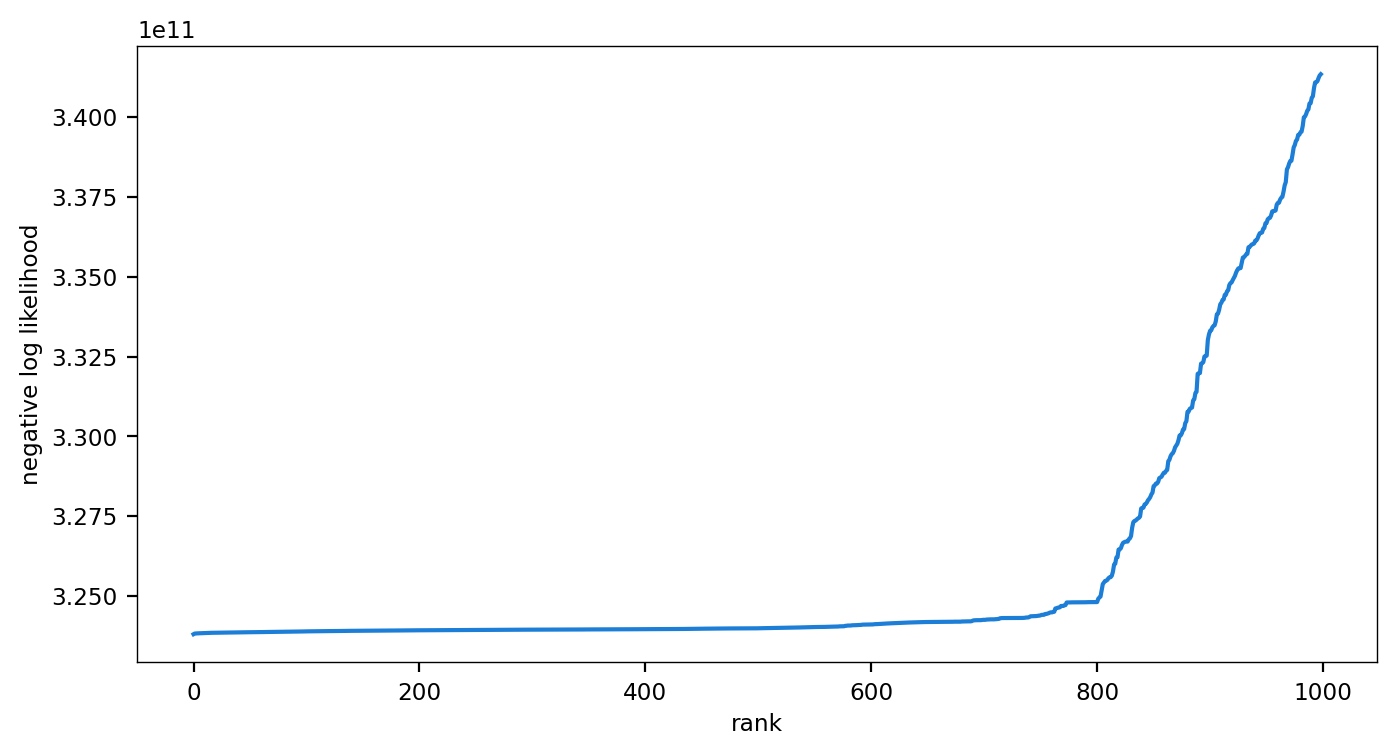

In [ ]:
thresh = 1
plt.plot(np.arange(len(nlls))[:-thresh], np.sort(nlls)[:-thresh])
plt.ylabel('negative log likelihood')
plt.xlabel('rank')

In [ ]:
a = mb.optim.thetas_
nlls = mb.optim.nlls_

In [ ]:
mle = load_pickle('../fits/hg38_cds_utrs_phastcons_merged_simplex/fit_1000000/mle.pkl')

In [ ]:
mle = load_pickle('../fits/hg38_cds_utrs_phastcons_merged_simplex/fit_1000000/mle_softmax.pkl')

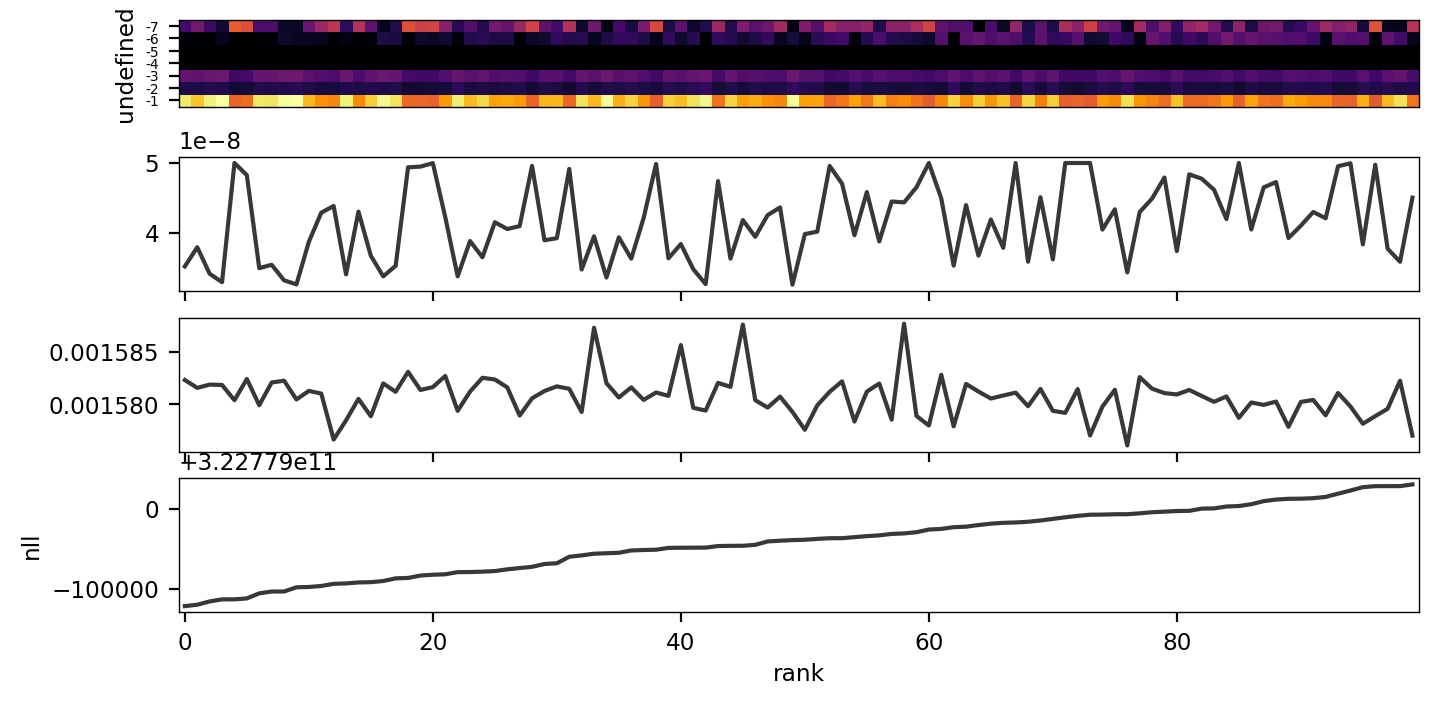

In [ ]:
from bgspy.optim import optim_diagnotics_plot
optim_diagnotics_plot(mle['m_bp'], top_n=100)

In [ ]:
mle['m_bp'].bounds()

(array([5.e-04, 9.e-09, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00]),
 array([5.e-03, 5.e-08, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
        1.e+00]))

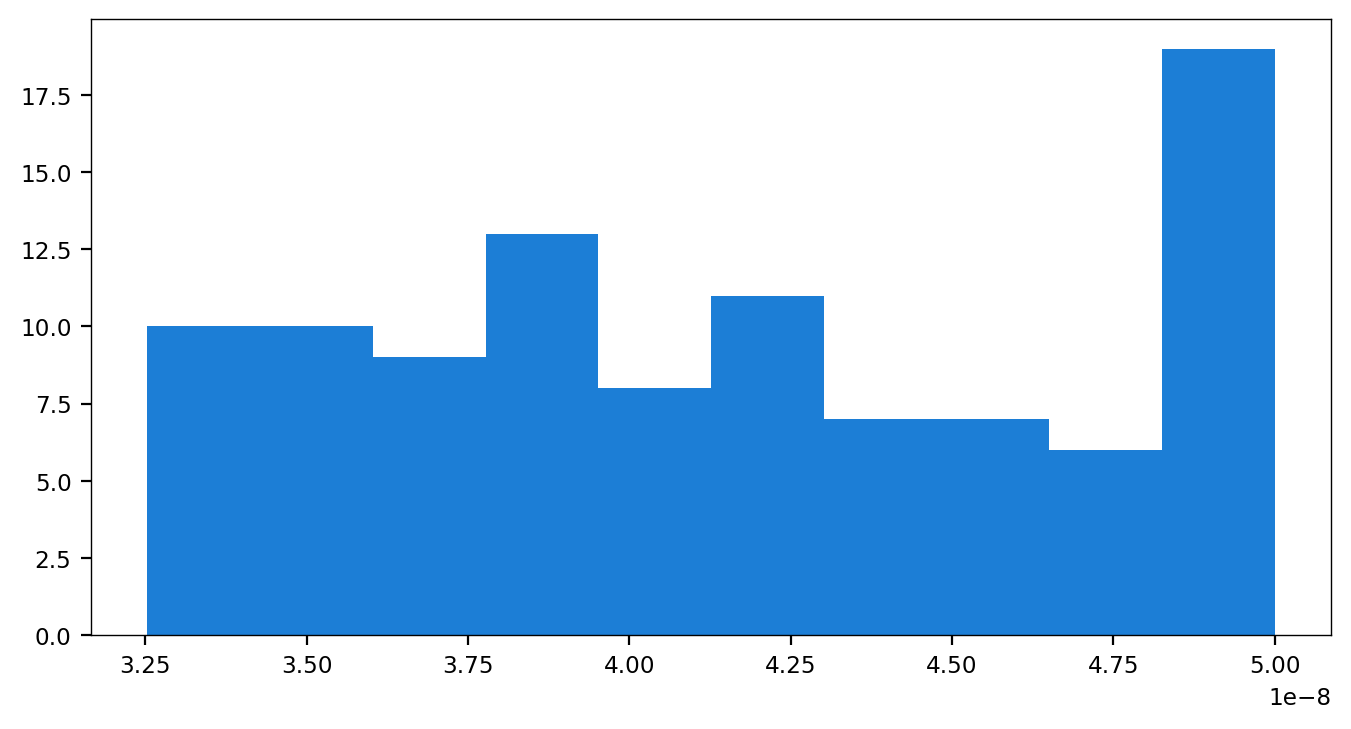

In [ ]:
_ = plt.hist([x[1] for x in mle['m_bp'].optim.thetas_[:100]])

Text(0.5, 0, 'rank')

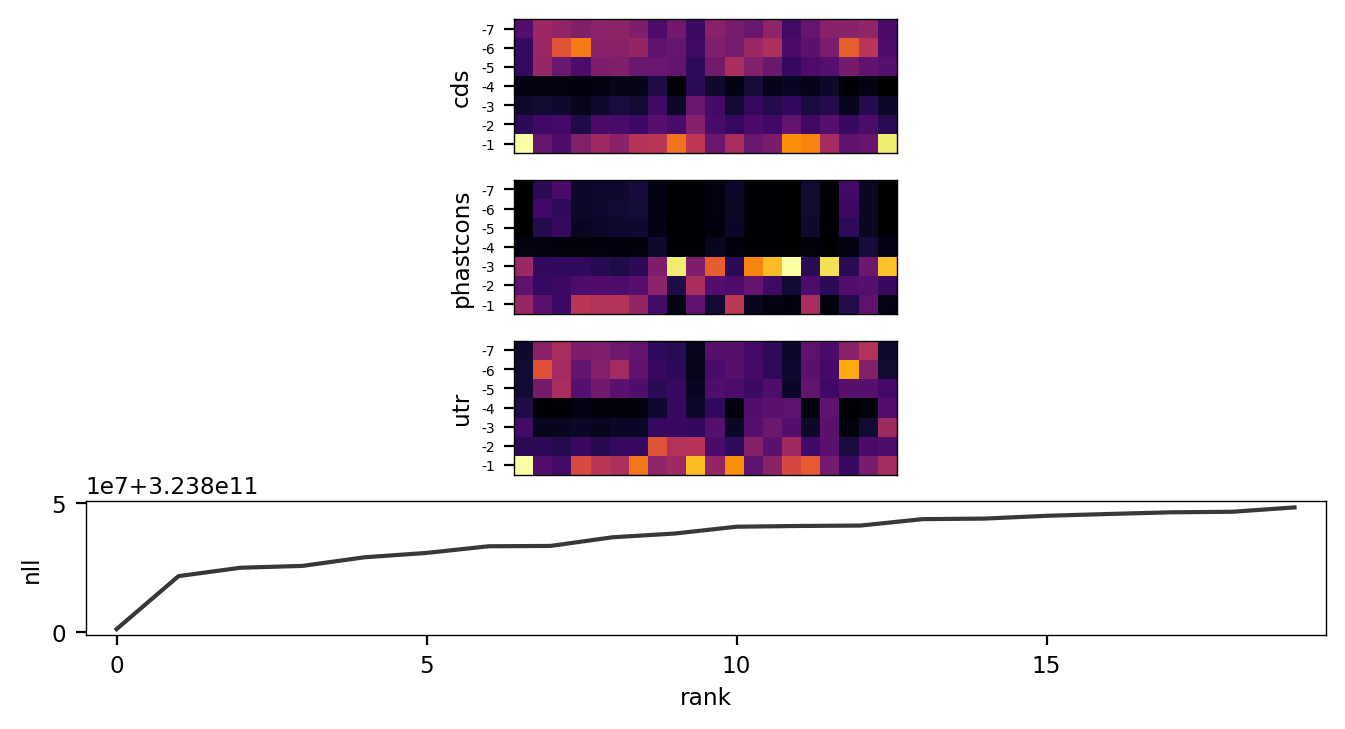

In [ ]:
top_n = 20

dfes = []
for i in range(top_n):
    dfes.append(softmax(a[nll_idx[i]].x[2:].reshape(mb.nt, mb.nf), axis=0))
    #dfes.append(softmax(a[i, :][2:].reshape(mb.nt, mb.nf), axis=0))

dfes = np.stack(dfes)
#dfes = dfes - np.mean(dfes, axis=0)

fig, ax = plt.subplots(ncols=1, nrows=mb.nf + 1, sharex=True)

for i in range(mb.nf):
    ax[i].imshow(dfes[:, :, i].T, cmap='inferno')
    ax[i].set_ylabel(f"{features[i]}")
    ax[i].set_yticks(np.arange(mb.nt), np.log10(mb.t).astype(int))
    ax[i].xaxis.set_visible(False)
    ax[i].tick_params(axis='y', which='major', labelsize=5)
thresh = 1
i += 1
# ax[i].scatter(np.arange(len(nlls))[:top_n], np.sort(nlls)[:top_n], 
#               c=[{True: 'black', False: 'red'}[x.success] for x in a][:top_n],
#              s=2)
ax[i].plot(np.arange(len(nlls))[:top_n], np.sort(nlls)[:top_n], c='0.22')
ax[i].set_ylabel('nll')
ax[i].set_xlabel('rank')


In [ ]:
mb.theta_ = a[min_i].x

In [ ]:
def convert_softmax(theta_sm):
    theta = np.copy(theta_sm)
    theta[2:] = softmax(theta[2:].reshape(mb.nt, mb.nf), axis=0).flat
    return theta

#mb.theta_ = mb.random_start() #convert_softmax(a[-1].x)
mb.theta_ = convert_softmax(a[min_i].x)
mb.nll_ = nlls[min_i]

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

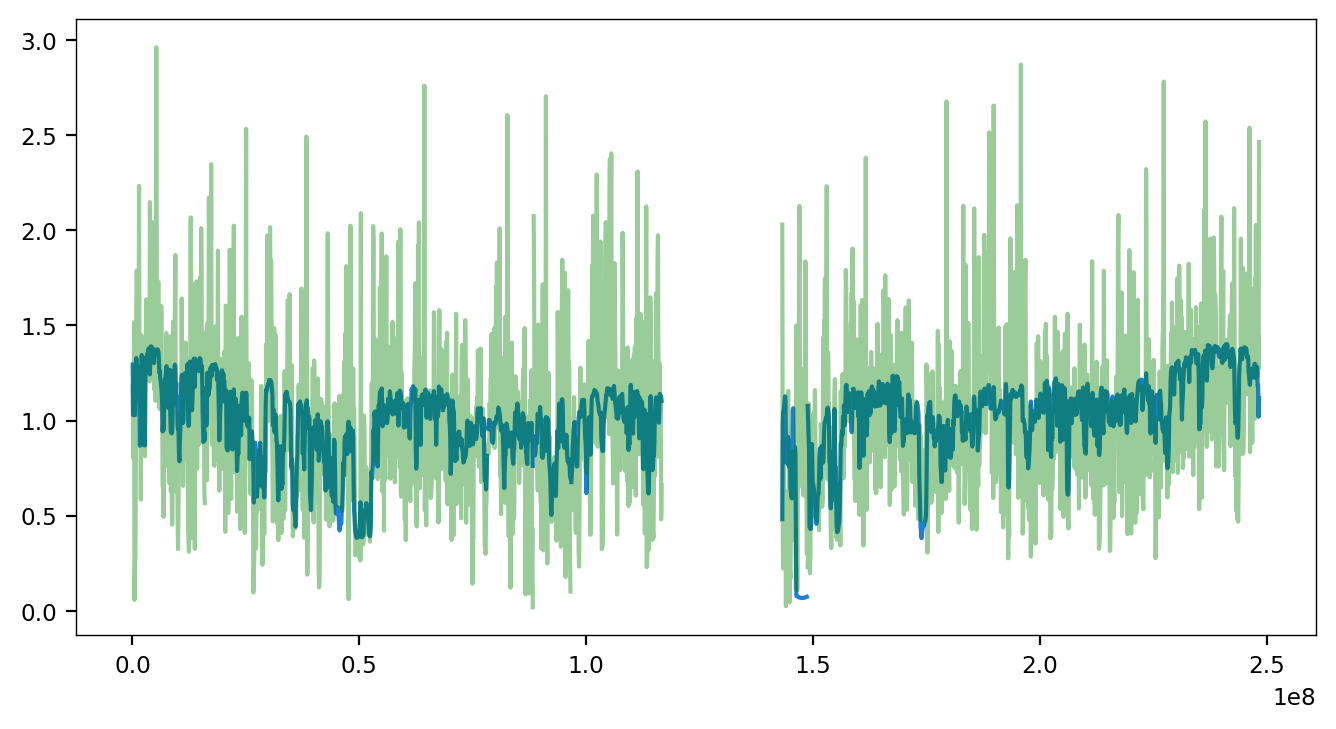

In [ ]:
mb.predict_plot('chr1')

In [ ]:
mb.fit(starts=100, ncores=70, softmax=True)

In [ ]:
mb.theta_ = convert_softmax(bfgs[min_i].x)

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

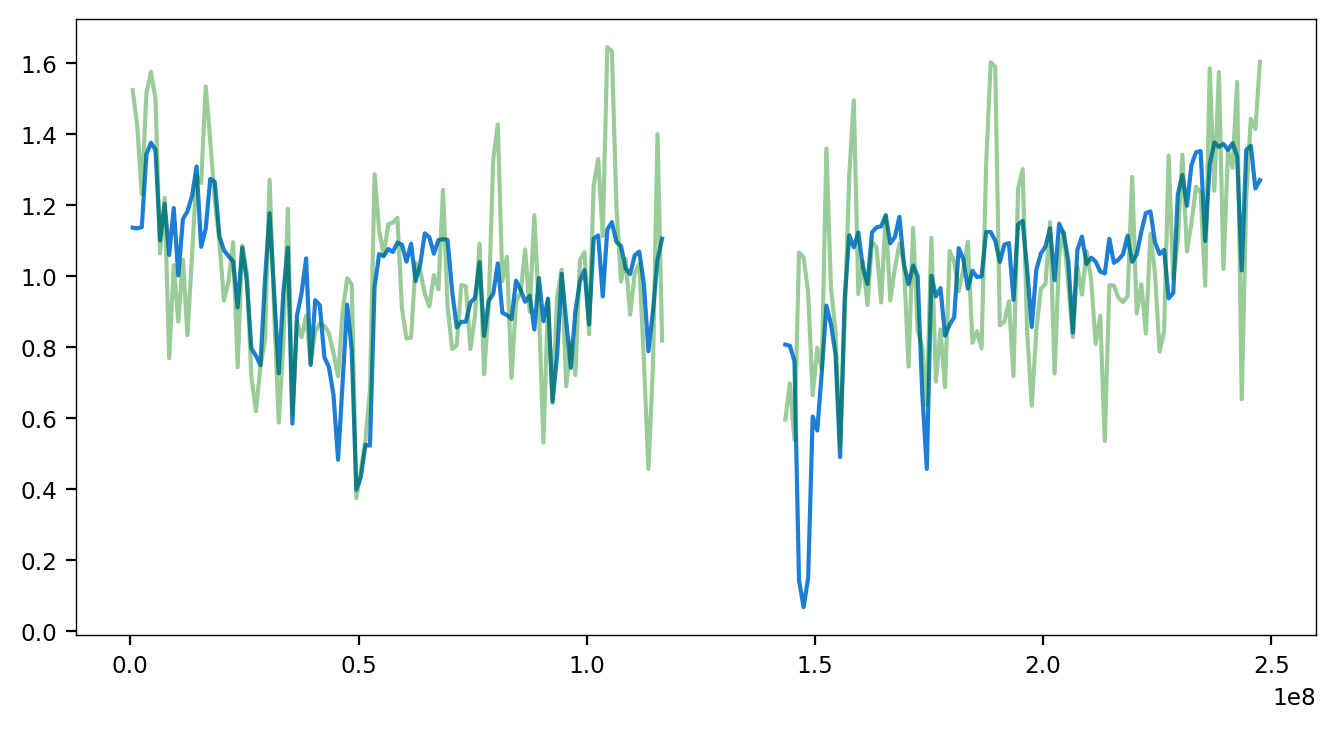

In [ ]:
mb.predict_plot('chr1')


(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot: xlabel='predicted $\\hat{\\pi}$', ylabel='residuals'>)

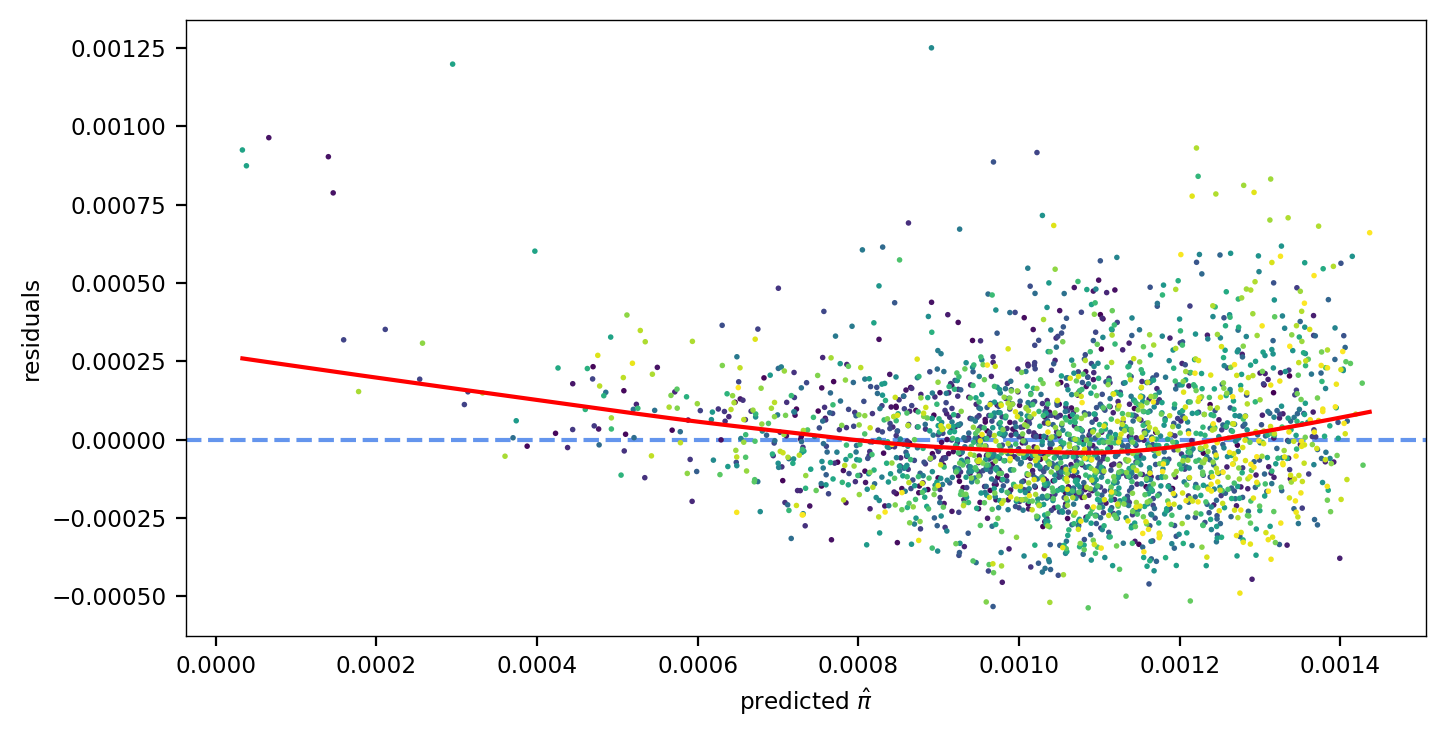

In [ ]:
mb.resid_fitted_plot()
#plt.semilogx()
#plt.xlim(1e-9, 1e-1)


(<Figure size 1600x800 with 1 Axes>, <AxesSubplot: >)

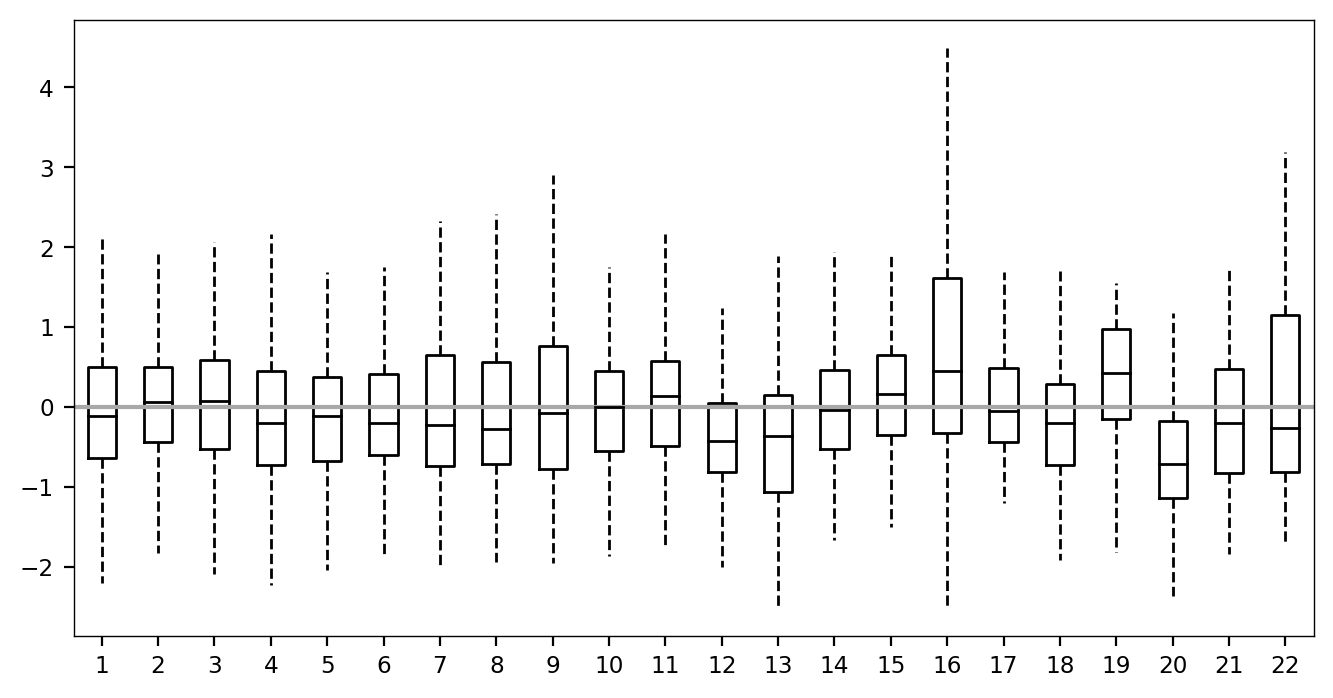

In [ ]:
mb.chrom_resid_plot()

In [ ]:
mb.nll_ = nlls[min_i]
mb

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 323801121624.9068
π0 = 0.001533083172058827
μ = 2.6506112791649518e-08
R² = 68.1189
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.131        0      0.055
1e-06   0.098        0      0.058
1e-05   0.096        0      0.057
0.0001  0.03         0.026  0.076
0.001   0.051        0.371  0.119
0.01    0.088        0.238  0.093
0.1     0.507        0.364  0.542

In [ ]:
%%time 
mb.fit(ncores=70, starts=100, start_pi0=0.0015, start_mu=3e-8, algo='GN_ISRES')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [56:34<00:00, 33.95s/it]


CPU times: user 785 ms, sys: 19 s, total: 19.8 s
Wall time: 56min 54s


In [ ]:
mb

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322730856130.1677
π0 = 0.001548282636298154
μ = 3.3456171082384254e-08
R² = 68.3494
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.083        0.002  0.175
1e-06   0.865        0      0.025
1e-05   0.029        0      0.029
0.0001  0            0      0.039
0.001   0            0.238  0.115
0.01    0            0.359  0.067
0.1     0.024        0.402  0.549

In [ ]:
m_b.optim

OptimResult
  termination code: xtol reached
  stats: {'xtol reached': 1992, 'max eval': 8} (prop success: 100.0%)
  negative log-likelihood = 322778981134.79486
  theta = [1.58288477e-03 3.00449198e-08 3.60169419e-04 5.06109943e-04
 2.42576328e-05 2.81284967e-04 2.14794012e-01 8.35385118e-02
 7.00650041e-01]

In [ ]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322778994608.46765
π0 = 0.001582883595483872
μ = 4.496758587745205e-08
R² = 66.6214
W = 
          undefined
------  -----------
1e-07         0.313
1e-06         0.018
1e-05         0
0.0001        0
0.001         0.142
0.01          0.061
0.1           0.465

In [ ]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322778986520.9623
π0 = 0.0015824358718647073
μ = 3.281030904802272e-08
R² = 66.6248
W = 
          undefined
------  -----------
1e-07         0.071
1e-06         0.014
1e-05         0
0.0001        0
0.001         0.196
0.01          0.079
0.1           0.639

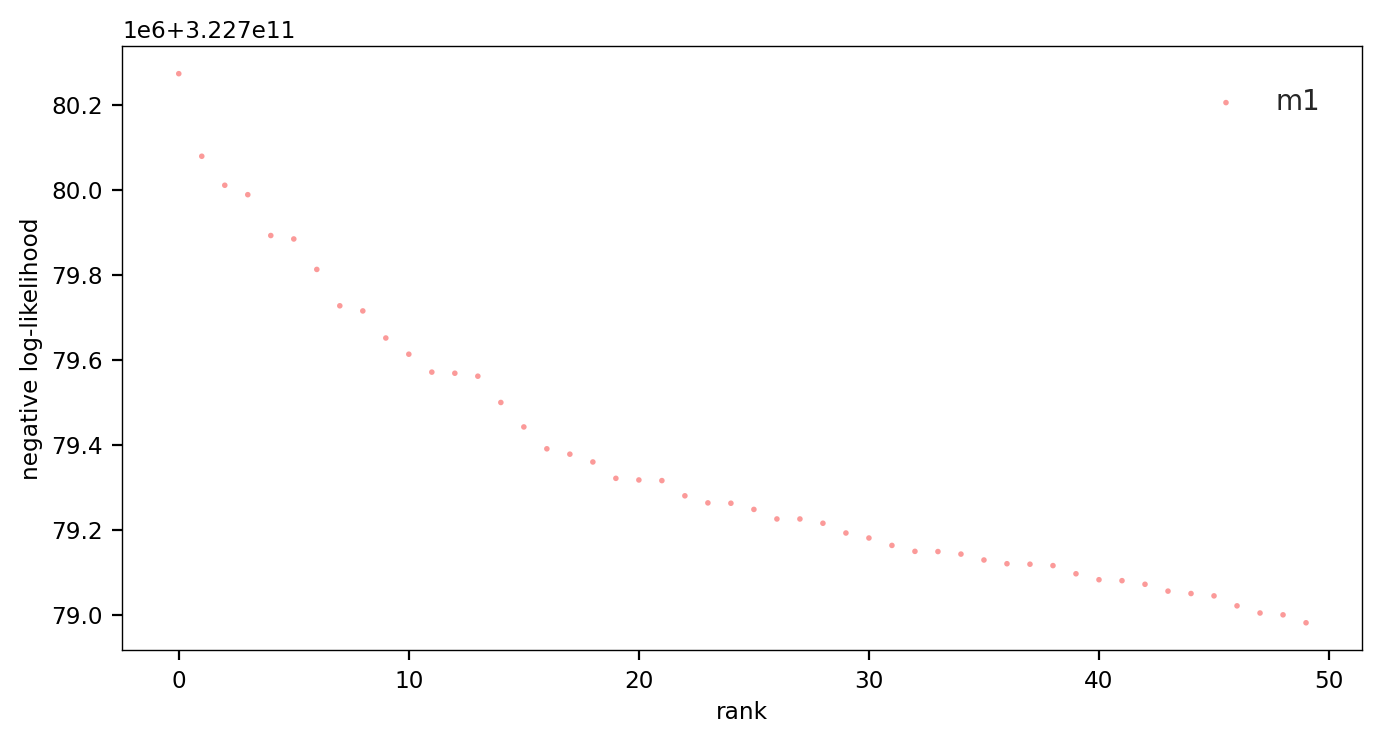

In [ ]:
optim_plot(m1=mb.optim)

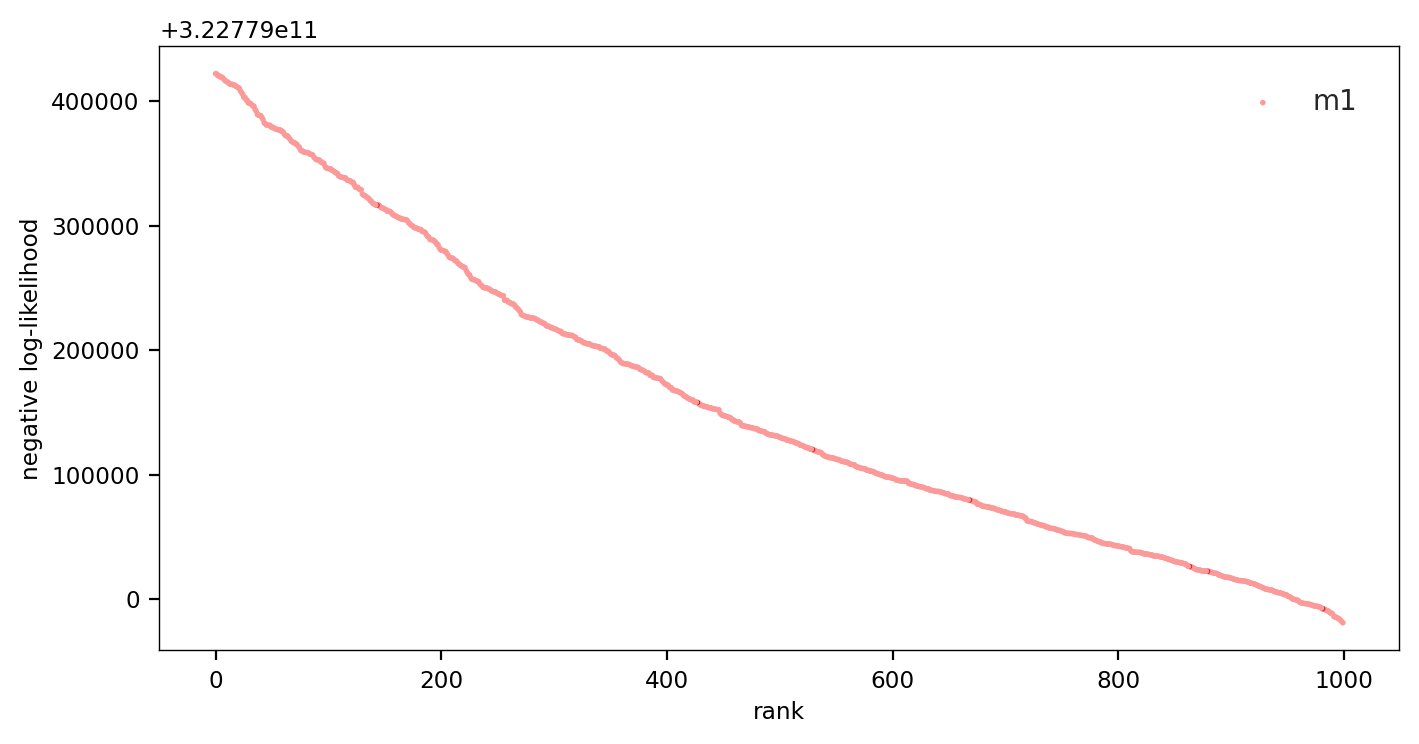

In [ ]:
optim_plot(m1=m_b.optim)

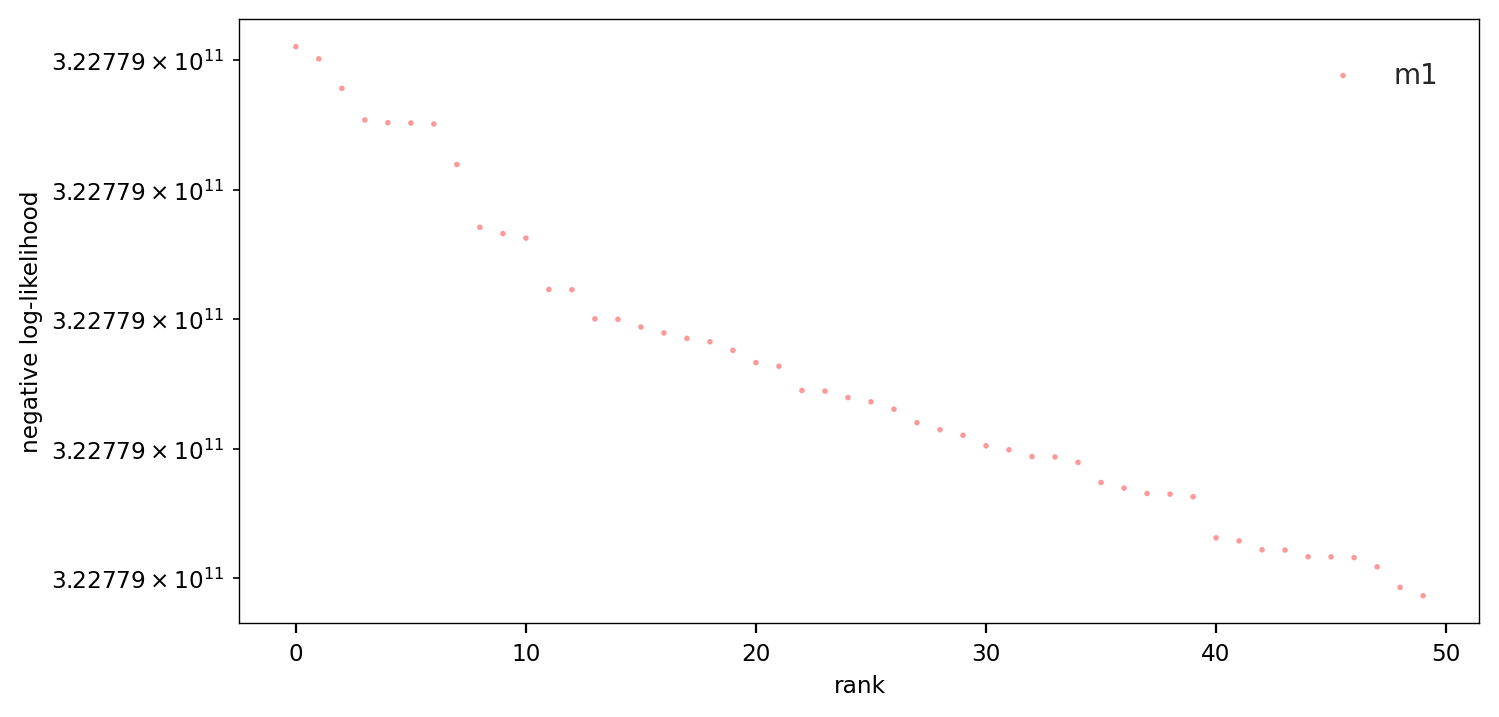

In [ ]:
optim_plot(m1=m_b.optim)

In [ ]:
m_b.fit(ncores=50, starts=1, start_pi0=0.0015, start_mu=3e-8, algo='GN_ISRES')

  0%|          | 0/1 [00:00<?, ?it/s]

> /home/vsb/projects/bprime/bgspy/optim.py(188)nlopt_simplex_worker()
    186     log10_mu_bounds = bounds[0][1], bounds[1][1]  # TODO CHECK
    187     __import__('pdb').set_trace()
--> 188     hl, hu = inequality_constraint_functions(nt, nf, mu=mu, 
    189                                              log10_mu_bounds=log10_mu_bounds)
    190     # tolerances for inequality constraint



ipdb>  log10_mu_bounds


(1e-11, 1e-07)


ipdb>  exit


BdbQuit: 

### CDS + UTRs + Phastcons Model

In [ ]:
fd = load_pickle('../fits/hg38_cds_utrs_phastcons_simplex/model_data.pkl')
gm, Y, bgs_bins, features, bp = fd['gm'], fd['Y'], fd['bgs_bins'], fd['gm'], fd['bp']

In [ ]:
10**np.array(tuple(np.log10((0.0005, 0.005))))

array([0.0005, 0.005 ])

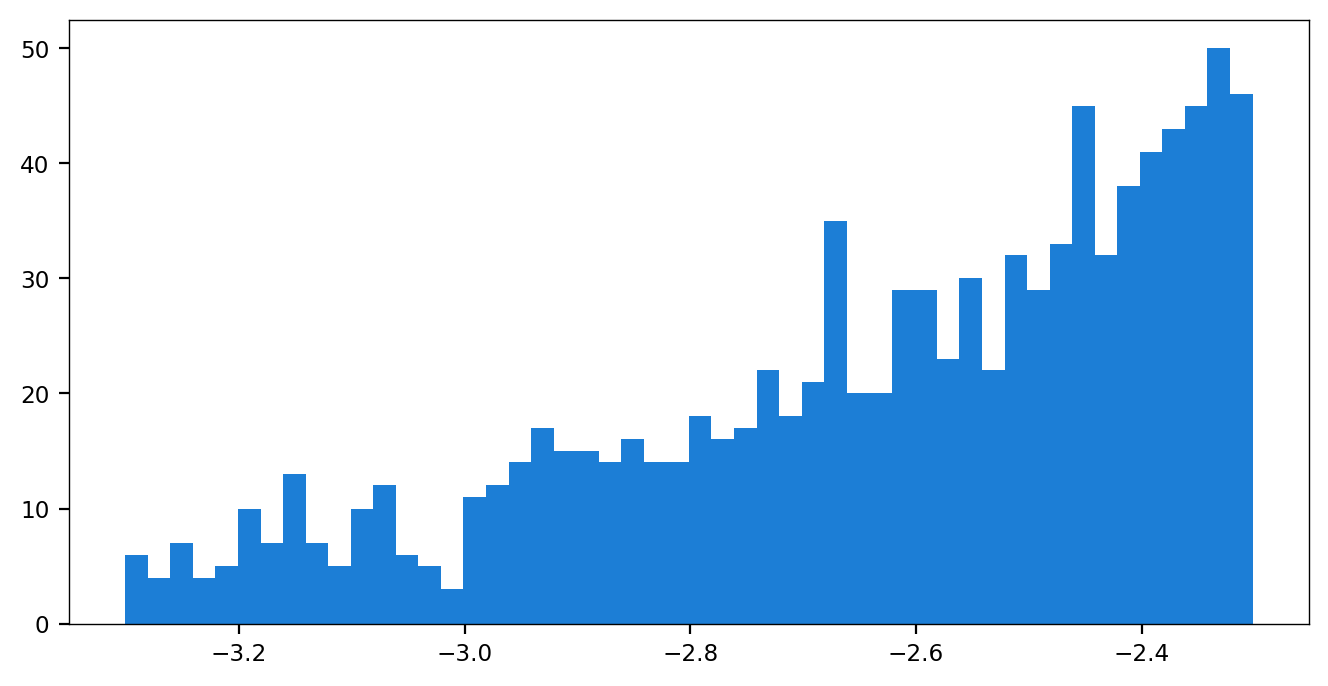

In [ ]:
_ = plt.hist(np.log10([m_b.random_start()[0] for x in range(1000)]), 50)

In [ ]:
from bgspy.data import pi_from_pairwise_summaries
pi_from_pairwise_summaries(Y.sum(axis=0))

0.001052746703898515

In [ ]:
m_b

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322791293316.3191
π0 = 0.0015787476785369746
μ = 6.407820745658771e-08
R² = 66.2317
W = 
          undefined
------  -----------
1e-07         0.022
1e-06         0.393
1e-05         0.127
0.0001        0
0.001         0.064
0.01          0.112
0.1           0.281

In [ ]:
m_b

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 322741693444.99133
π0 = 0.001559728773284351
μ = 3.855877895183788e-08
R² = 67.8068
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.32         0.055  0.241
1e-06   0.228        0.007  0.202
1e-05   0.008        0.003  0.133
0.0001  0.001        0.001  0.02
0.001   0.001        0.148  0.063
0.01    0.266        0.414  0.196
0.1     0.177        0.372  0.146

In [ ]:
%%time
m_b.fit(ncores=70, starts=100, algo='GN_ISRES')

  0%|          | 0/100 [00:00<?, ?it/s]

Process ForkPoolWorker-140:
Process ForkPoolWorker-136:
Process ForkPoolWorker-117:
Process ForkPoolWorker-88:
Process ForkPoolWorker-125:


KeyboardInterrupt: 